In [174]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from math import floor
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.core.display import HTML
from IPython.core.display import display
from IPython.display import Image 
from matplotlib.ticker import FuncFormatter

SEQUENCE_LENGTH = 8
PREDICTION_DELTA = 4
BATCH_SIZE = 1
TRAIN_STEPS = 90000
DISPLAY_STEPS = 5000

FILE_NAME = "_s:{}_p:{}".format(SEQUENCE_LENGTH, PREDICTION_DELTA)

def LoadCleanData(name):
    training_data = np.load('data/' + name + FILE_NAME + "_training_data.npy" )
    lables = np.load('data/' + name + FILE_NAME + "_lables.npy")

    training_data = training_data[..., 1] # use only 'views'

    training_data[training_data == 0] = 1
    lables[lables == 0] = 1

    training_data =  np.log(training_data)
    lables = np.log(lables)

    return training_data, lables

def GetNextBatch(inputs, lables, batchId):
    batchId = batchId % len(inputs)
    startIndex = batchId * BATCH_SIZE
    endIndex = (batchId + 1) * BATCH_SIZE
    if(len(inputs) < endIndex):
        startIndex = 0
        endIndex = BATCH_SIZE

    return (inputs[startIndex:endIndex], lables[startIndex:endIndex])

In [175]:
train_inputs, train_lables = LoadCleanData("TRAIN")

In [1]:
X = tf.placeholder("float", shape=(None, SEQUENCE_LENGTH), name="Inputs") 
Y = tf.placeholder("float", shape=(None, 1), name="Outputs")

W = tf.Variable(tf.ones([SEQUENCE_LENGTH, 1]), name="weight") 

pred = tf.reduce_sum(tf.matmul(X,W), axis=1)

loss = tf.reduce_mean(tf.square(pred/Y - 1)) # RSE

optimizer = tf.train.AdamOptimizer(2e-3)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for step in range(TRAIN_STEPS):
    training_data, lables = GetNextBatch(train_inputs, train_lables, step)
    inputs = np.reshape(training_data, (BATCH_SIZE, SEQUENCE_LENGTH))
    output = np.reshape(lables, (BATCH_SIZE, 1))

    sess.run(train, feed_dict={X: inputs, Y: output})
    if step % DISPLAY_STEPS == 0:
        print(step, sess.run(loss, feed_dict={X: inputs, Y: output}))


test_inputs, test_lables = LoadCleanData("TEST")

test_lables = np.reshape(test_lables, (len(test_lables), 1))
predictTest =  sess.run(pred, feed_dict={X: test_inputs})

originalPredicted = np.exp(np.array(predictTest))
originalTestOutputs = np.exp(test_lables.ravel())
rse = ((originalPredicted / originalTestOutputs) - 1) ** 2
mapeAr = abs(1 - (originalPredicted / originalTestOutputs))


print("Test RSE stats. Mean: %f, Std: %f Var: %f" % (rse.mean(), rse.std(), rse.var()))
print("Test MAPE stats. Mean: %f, Std: %f Var: %f" % (mapeAr.mean(), mapeAr.std(), mapeAr.var()))



NameError: name 'tf' is not defined

In [2]:
def split_to_data_and_lables(dataFrame, time_steps, lable_delta):
    sourceDatas = []
    labels = []
    dates = []

    dataFrame = dataFrame.reset_index()

    for i in range(len(dataFrame) - time_steps):
        dataEnd = i + time_steps
        lableId = dataEnd + lable_delta - 1
        if lableId < len(dataFrame):
            lable = dataFrame['views'][lableId]
            labels.append(lable)

            date = dataFrame['date'][lableId]
            dates.append(date)

            curData = dataFrame.iloc[i: dataEnd]
            npAr = curData.as_matrix(['views'])
            sourceDatas.append(npAr)

    return sourceDatas, labels, dates

In [178]:
def PlotVideoStats(videoDf):
    videoId = videoDf['videoid'][0]

    print("Video:")
    link = "https://www.youtube.com/watch?v=" + videoId
    display(HTML('<a href="' + link + '">' + link + '</a>'))
    display(Image("https://img.youtube.com/vi/" + videoId + "/mqdefault.jpg"))

    data, labels, dates = split_to_data_and_lables(videoDf, time_steps = SEQUENCE_LENGTH, lable_delta=PREDICTION_DELTA)
    
    predicted = []
    real = []
    
    for i in range(len(data)):
        sequence = np.log(data[i])
        lable = labels[i]
        prevLable = lable
        curInput = np.reshape(sequence, (1, SEQUENCE_LENGTH))
        predictedLogResult = sess.run(pred, feed_dict={X: curInput})
        predictedResult = np.exp(predictedLogResult.ravel())
        predicted.append(predictedResult)
        real.append(lable)

    realDf = pd.DataFrame(columns=['date', 'views'])
    realDf['date'] = dates
    realDf['views'] = real
    realDf = realDf.set_index(['date'])

    predictedDf = pd.DataFrame(columns=realDf.columns, index=realDf.index)
    predictedDf['views'] = predicted
    
    plt.figure(figsize=(12,5))
    plot_predicted, = plt.plot(predictedDf['views'], label='predicted')
    plot_test, = plt.plot(realDf['views'], label='real')
    plt.legend(handles=[plot_predicted, plot_test])
    plt.ylabel('Video views')
    plt.xlabel('Date')
    plt.title('Prediction perfomance')
    
    plt.show()

    predictedAr = np.array(predicted).ravel()
    realAr = np.array(real).ravel()
    mapeAr = abs(1 -  predictedAr/realAr)
    
    plt.figure(figsize=(12,5))
    plt.plot(mapeAr)
    plt.title('MAPE perfomance')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    plt.xlabel('Weeks from the video publication')
    plt.ylabel('Mean absolute percentage error')
    
    plt.show()

In [179]:
dataFrames = pickle.load(open('top10.p', 'rb'))

Video:


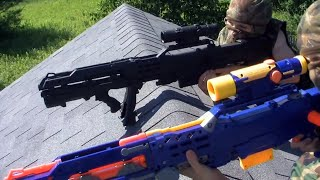

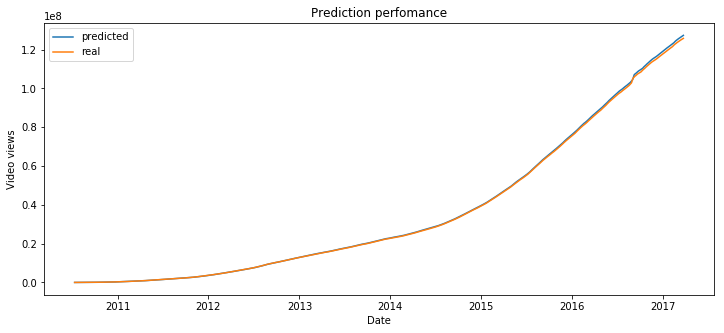

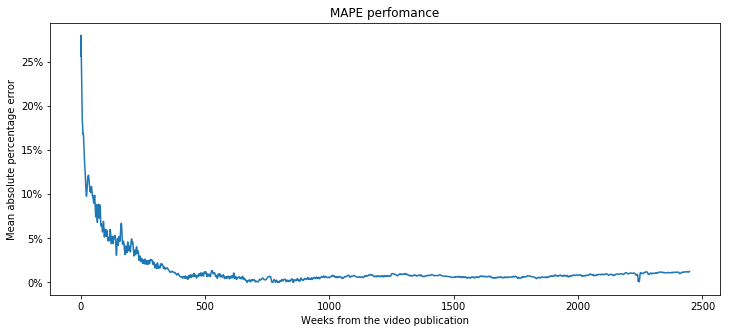

In [180]:
PlotVideoStats(dataFrames[0])

Video:


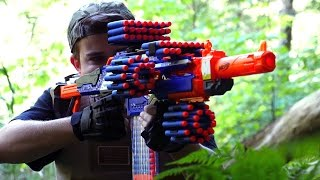

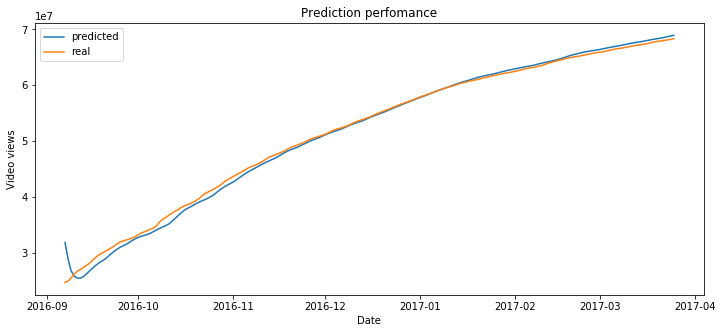

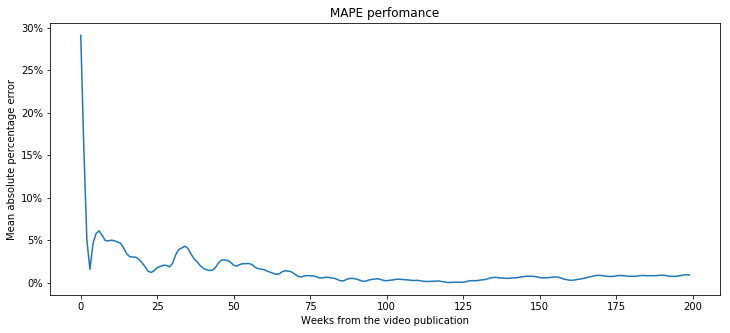

In [181]:
PlotVideoStats(dataFrames[1])

Video:


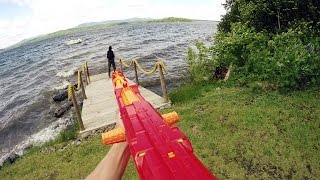

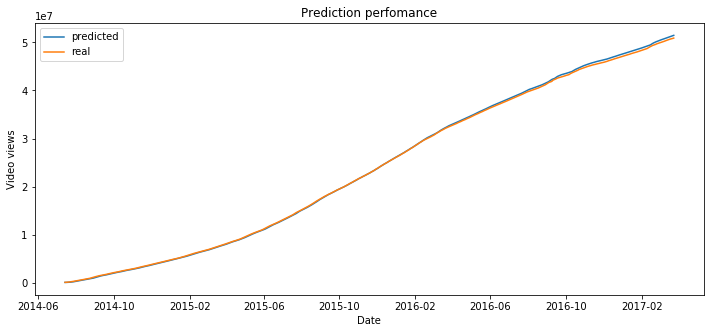

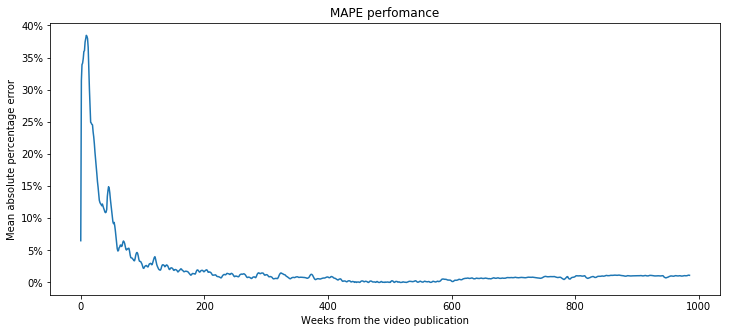

In [182]:
PlotVideoStats(dataFrames[2])

Video:


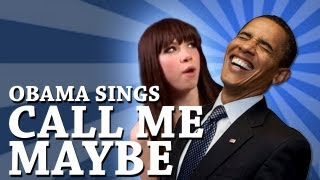

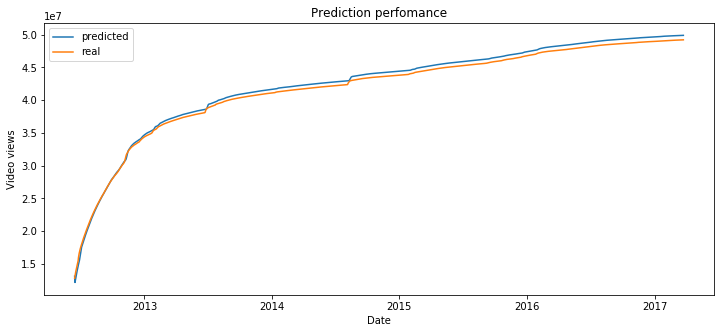

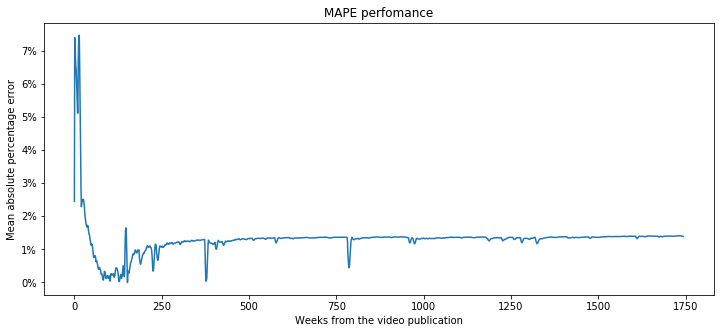

In [183]:
PlotVideoStats(dataFrames[3])

Video:


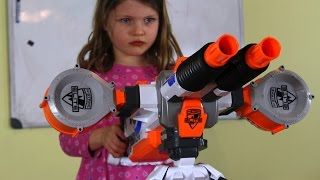

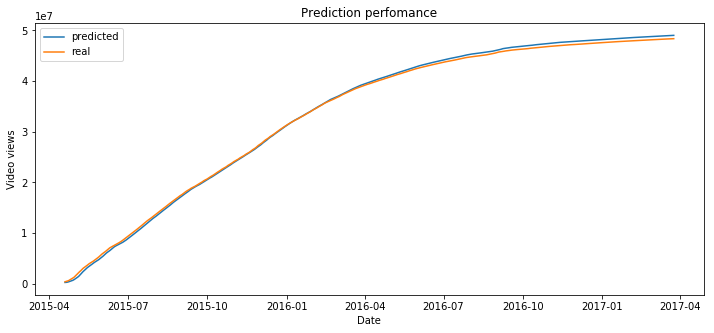

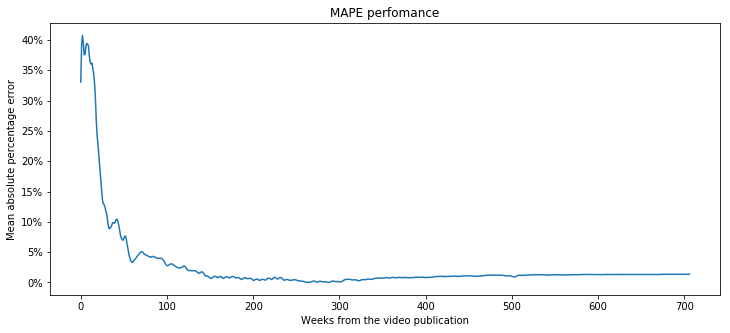

In [184]:
PlotVideoStats(dataFrames[4])

Video:


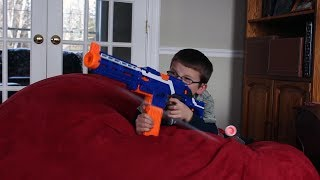

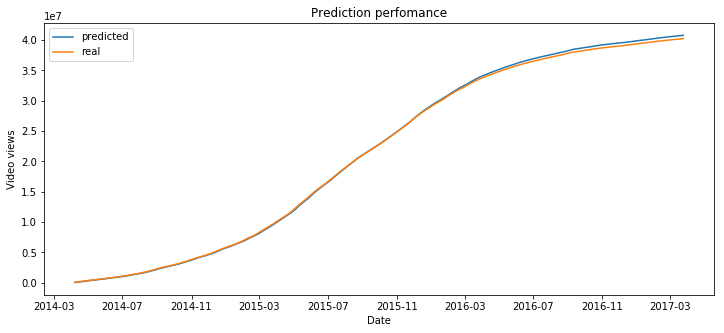

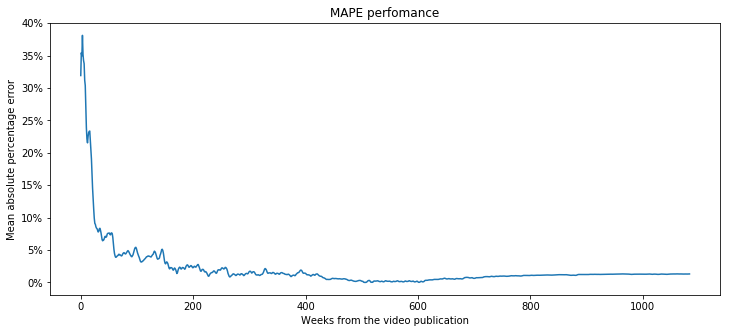

In [185]:
PlotVideoStats(dataFrames[5])

Video:


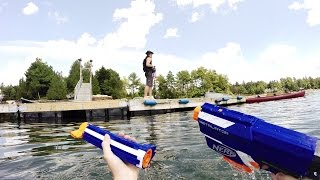

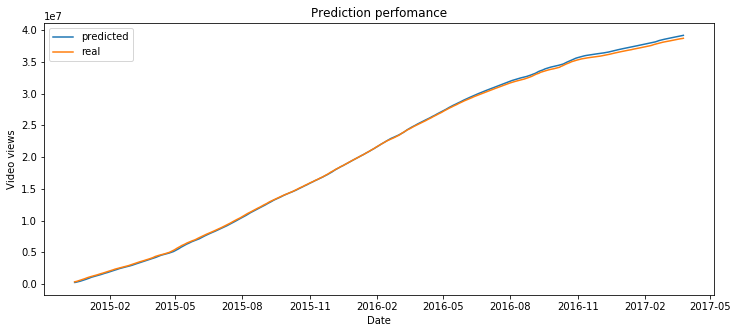

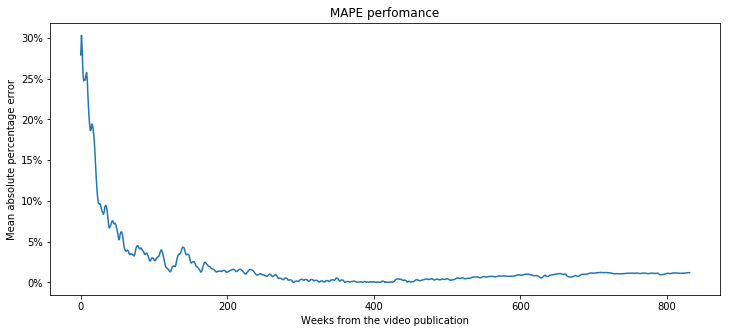

In [186]:
PlotVideoStats(dataFrames[6])

Video:


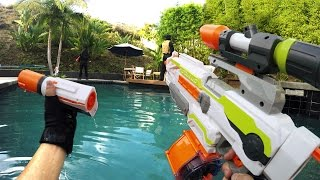

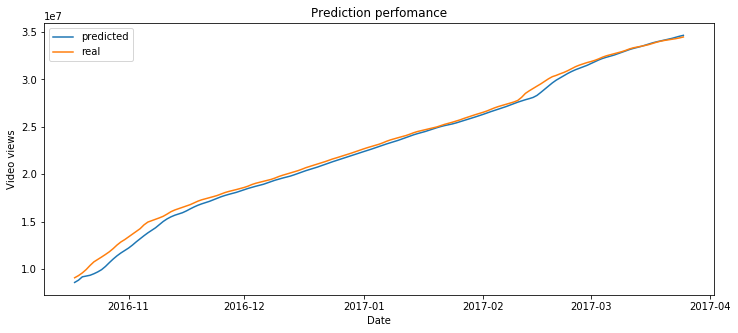

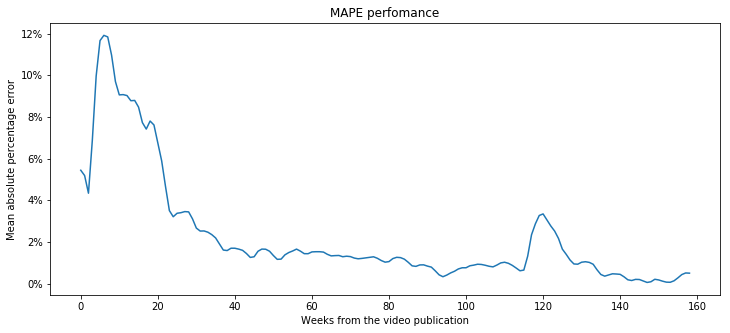

In [187]:
PlotVideoStats(dataFrames[7])

Video:


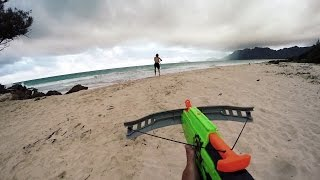

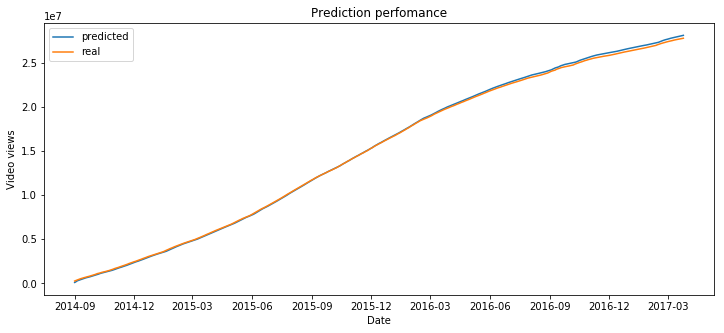

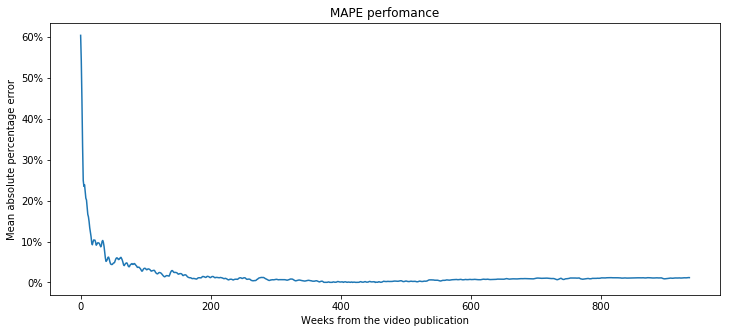

In [188]:
PlotVideoStats(dataFrames[8])

Video:


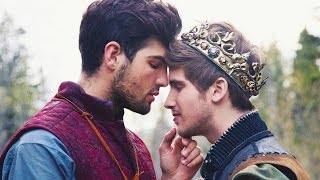

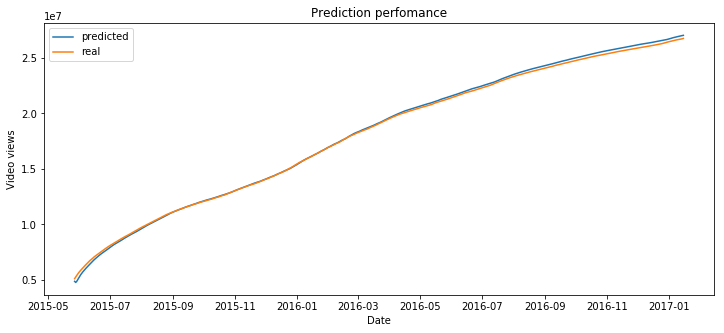

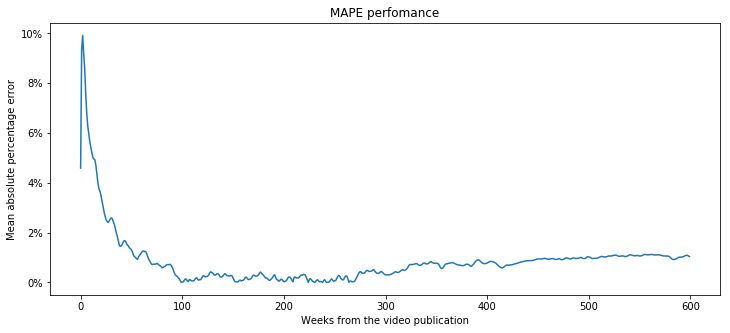

In [189]:
PlotVideoStats(dataFrames[9])